# Evaluating a simple spectrogram normalizer to counteract effect of non-flat spectra due to filter banks
This notebook does the following:
1) Generates spectrogram samples (tone+noise), zero drift for this evaluation
2) Performs non-coherent averaging 
3) Applies simple_norm.py normalization and thresholding algorithms
4) Plots spectra and tone detections for selected values of number of averages,
and number of subbands.  For sufficient subbands, tones are detected as expected, even at the far edges of the coarse channel band.



In [1]:
import sys
import os

#matplotlib inline
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'medium',
          'figure.figsize': (10,6),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)

import numpy as np
import scipy as sp
from scipy.fft import fft, fftshift

import time

from pathlib import Path
from numpy.random import default_rng

from simple_norm import simple_norm

from detect_tones import detect1D, add_detection
from gen_simple_coarse_sg import gen_simple_coarse_sg

import plot_fns as pltg             # generic plot fns

from numpy.random import randn, rand, randint, seed
seed(22)

import std_fns as s


In [2]:
fine_fft_size = 1024*512
n_time = 512
n_subband = 1
dc_offset = 0
dc_phase = (1+1j)/np.sqrt(2.)
i_case = 2
freq = np.linspace(-.5,.5,fine_fft_size,endpoint=False)
dc_reject = 1
tone_snr_db = 3.5
tone_freq = np.arange(-.45,.46,.10) 
tone_enable = 1
shear_threshold = 2.3
display_figs = False

pfb_file_enable = True
pfb_order = 8

if pfb_file_enable:
    if (pfb_order==4):
        pfb_file = 'chnl_512K_4_256ch.f32'
    elif (pfb_order==8):
        pfb_file = 'chnl_512K_8_256ch.f32'
    elif (pfb_order==12):
        pfb_file = 'chnl_512K_12_256ch.f32'
    else:
        print(f'Error in eq pfb_order={pfb_order}: no pfb file defined')
        assert(False)
    H_edge_db = 0.
else:
    pfb_file = ''
    H_edge_db = -3.
    # H_edge_db = -5.
    pfb_order = 0

z_det = 10.

output_dir = f'./poc_norm_plots_{pfb_order}/'
if not os.path.isdir(output_dir[0:-1]):
    os.system('mkdir '+output_dir[0:-1])



#### Read in PFB frequency response file

File chnl_512K_8_256ch.f32 read complete


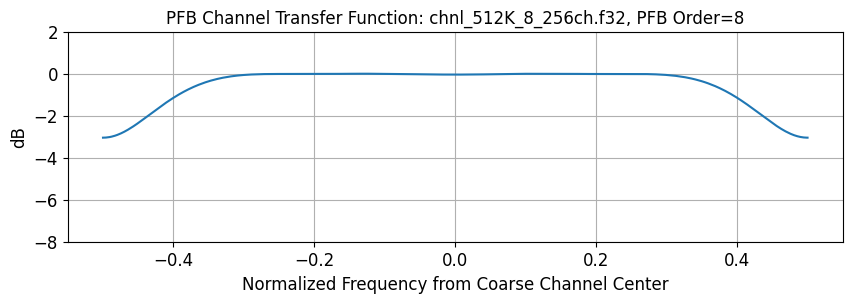

In [3]:
if pfb_file_enable:
    # Read in file
    try:
        with open(pfb_file, 'rb') as f:
            Hsq_pfb = np.fromfile(f, dtype=np.float32)
            Hsq_pfb_db = s.db(Hsq_pfb)
            print(f'File {pfb_file} read complete')

            if (len(Hsq_pfb) != fine_fft_size):
                print(f'Error in eq filter length {len(eq_db)} vs {fine_fft_size}')
                assert(False)

            pfb_freq =  np.linspace(-0.5,0.5,fine_fft_size,endpoint=False)

            fig = plt.figure(figsize=(10, 6))
            
            plt.subplot(2,1,1)
            pltg.plot_generic(x_data=pfb_freq,y_data=Hsq_pfb_db,
                fig = fig,
                y_limits=[-8.,2.],
                x_label = 'Normalized Frequency from Coarse Channel Center',
                y_label = 'dB',
                fig_title = 'PFB Channel Transfer Function: ' + pfb_file + f', PFB Order={pfb_order}')
            plt.savefig(output_dir+f'05-pfb-filter-{pfb_file}.png',bbox_inches='tight')
                
            plt.show()
            
    except FileNotFoundError:
        print(f"Error: File not found at {pfb_file}")


In [4]:
#
# generate spectrogram for single coarse channel
#

n_sti=1
# n_sti=n_time
dc = dc_offset*dc_phase

if (i_case==1):
    n_pol=1
else:
    n_pol=2

[sg,freq,Hsq]=gen_simple_coarse_sg(n_time,fine_fft_size,n_sti,H_edge_db,n_pol,dc,tone_freq,tone_snr_db)

if pfb_file_enable:
    Hsq = Hsq_pfb
    for i_time in range(n_time):
        for i_freq in range(fine_fft_size):
            sg[i_time,i_freq] *= Hsq_pfb[i_freq]

if dc_reject:
    sg[:,fine_fft_size//2]=n_pol

if (n_sti==n_time):
    sg = np.reshape(sg,(fine_fft_size))
    
f0 = freq[0]
df = freq[1]-freq[0]


tone_freq=array([-0.45, -0.35, -0.25, -0.15, -0.05,  0.05,  0.15,  0.25,  0.35,
        0.45])

tone_snr_db=array([3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5])



In [5]:
import matplotlib.pyplot as plt
#matplotlib inline

n_subband_list = [1, 32, 128]
n_avg_plot = [32,n_time]

log2_n_avg = round(np.log2(n_time))

avg_mean_std_ratio = np.zeros((len(n_subband_list),log2_n_avg))
expected_mean_std_ratio = np.zeros(log2_n_avg)

for i_sb_list,n_subband in enumerate(n_subband_list):
    print(f'{n_subband=}')
        
    for i_avg in range(log2_n_avg):
        n_avg = n_sti* 2**(i_avg+1)
        n_line_avg = 2**(i_avg+1)

        print(f'{n_sti=}, {n_line_avg=}, {n_avg=}')

        #
        # sum spectroram rows
        #

        col_sum = np.mean(sg[0:n_line_avg,:],0)

        #
        # normalize spectrum
        #

        print('Running simple_norm')
        [norm1, Hsq_est, mean1, std1] = simple_norm(col_sum,shear_threshold,n_subband=n_subband)

        col_sum_db = s.db(col_sum)
        
        norm1_db = s.db(norm1)
        Hsq_db = s.db(Hsq)
        Hsq_est_db = s.db(Hsq_est)

        mean1_db = s.db(mean1)
        threshold1_db = s.db(mean1 + z_det*std1)

        # np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
        # print('mean:')
        # print(mean1)
        # print('std:')
        # print(std1)
        # print('Threshold dB:')
        # print(threshold1_db)

        expected_mean_std_ratio[i_avg] = np.sqrt(2.*n_avg) 
        mean_std_ratio = np.zeros(n_subband)
        if (n_subband>1):
            for i_sb in range(n_subband):
                mean_std_ratio[i_sb] = mean1[i_sb]/std1[i_sb]
                avg_mean_std_ratio[i_sb_list,i_avg] = np.mean(mean_std_ratio)
        else:
                mean_std_ratio[0] = mean1/std1
                avg_mean_std_ratio[i_sb_list,i_avg] = mean_std_ratio[0]
        
        mean_std_string = f'{n_avg=:3d} mean/std={avg_mean_std_ratio[i_sb_list,i_avg]=:.2f} vs {expected_mean_std_ratio[i_avg]:.2f} expected'
        print(mean_std_string)

        #
        # find detections
        #
        
        [n_det,det_out]=detect1D(norm1,f0,df,n_subband,mean1,std1,z_det,verbose=False)

        # print(f'{n_avg=}, {n_det=}')
        # print(det_out)
        
        if (n_det>0):
            f_det = np.array(det_out.loc[:,"freq"])
            det_peak_db = np.array(det_out.loc[:,"peak_db"])
            margin_list_db = np.array(det_out.loc[:,"margin_db"])
            mean_margin_db = np.mean(margin_list_db)
            snr_list_db = np.array(det_out.loc[:,"snr_db"])
            mean_snr_db = np.mean(snr_list_db)
        else:
            f_det = []
            det_peak_db = []
            margin_list_db = []
            mean_margin_db = np.nan
            snr_list_db = []
            mean_snr_db = np.nan
        
        #
        # find detections
        #

        f_subband = np.linspace(-.5,.5,n_subband,endpoint=False)+1/n_subband/2
    
        result_str1 = f'#Averages={n_avg:4d}, #subbands={n_subband}\n#Dets={n_det}, Mean Margin={mean_margin_db:.2f} dB'
        print(result_str1)
    
        config_str1 = f'#Averages={n_avg:4d}'
        result_str2 = f'#Averages={n_avg:4d}, #subbands={n_subband}\n#Dets={n_det}, Mean Margin={mean_margin_db:.2f} dB'
        
    
        #
        # plot output
        #

        if (n_avg == n_avg_plot[0]) | (n_avg == n_avg_plot[1]):
            if (n_avg == n_avg_plot[0]):
                fig1 = plt.figure(1,figsize=(10, 6))
                i_subplot = 1
            else:
                plt.figure(1)
                i_subplot = 2
            
            plt.subplot(2,1,i_subplot)
            plt.plot(freq,col_sum_db,'-',label='Averaged Spectrum')
            plt.xlim(-.5,.5)
            plt.ylim(-5.,15)
            if (i_subplot==1):
                plt.title(f'Averaged Specta Prior to Normalizaton, Nfft={fine_fft_size//1024}K, PFB Order={pfb_order}')
                plt.ylabel('Amplitude dB')
                plt.figtext(.15,.83,config_str1,fontsize=12)
                plt.legend(loc='upper right')
            else:
                plt.xlabel('Normalized Frequency within Coarse Channel')
                plt.ylabel('Amplitude dB')
                plt.figtext(.15,.41,config_str1,fontsize=12)
            plt.grid()

            if (n_avg == n_avg_plot[1]):
                plt.savefig(output_dir+f'02-simple-norm-input-{n_subband}-sb'+'.png',bbox_inches='tight')
                if display_figs:
                    plt.show()
                else:
                    plt.close(fig1)

        if (n_avg == n_avg_plot[0]) | (n_avg == n_avg_plot[1]):
            if (n_avg == n_avg_plot[0]):
                fig2 = plt.figure(2,figsize=(10, 6))
                i_subplot = 1
            else:
                plt.figure(2)
                i_subplot = 2
            
            plt.subplot(2,1,i_subplot)
            plt.plot(freq,norm1_db,'-',label='Normalized Spectrum')
            if (n_subband==1):
                plt.plot([-.5,.5],mean1_db*np.ones(2),'--',label='Spectrum Mean',linewidth=2.5)
                plt.plot([-.5,.5],threshold1_db*np.ones(2),'-r',label=f'Threshold z={z_det:.0f}',linewidth=2.5)
                plt.plot(f_det,det_peak_db,'*g',label=f'Detections',linewidth=2.5)
            else:
                plt.plot(f_subband,mean1_db,'--',label='Subband Mean',linewidth=2.5)
                plt.plot(f_subband,threshold1_db,'-*r',label=f'Threshold z={z_det:.0f}',linewidth=2.5)
                plt.plot(f_det,det_peak_db,'*g',label=f'Detections',linewidth=2.5)
            plt.xlim(-.5,.5)
            plt.ylim(-5.,15.)
            if (i_subplot==1):
                plt.title(f'Detected Tones after Normalization, Nfft={fine_fft_size//1024}K, PFB Order={pfb_order}')
                plt.ylabel('Amplitude dB')
                plt.figtext(.15,.81,result_str2,fontsize=12)
                plt.legend(loc='upper right')
            else:
                plt.xlabel('Normalized Frequency within Coarse Channel')
                plt.ylabel('Amplitude dB')
                plt.figtext(.15,.39,result_str2,fontsize=12)
            plt.grid()

            if (n_avg == n_avg_plot[1]):
                plt.savefig(output_dir+f'03-simple-norm-output-{n_subband}-sb'+'.png',bbox_inches='tight')
                if display_figs:
                    plt.show()
                else:
                    plt.close(fig2)


n_subband=1
n_sti=1, n_line_avg=2, n_avg=2
Running simple_norm
n_avg=  2 mean/std=avg_mean_std_ratio[i_sb_list,i_avg]=1.98 vs 2.00 expected
#Averages=   2, #subbands=1
#Dets=0, Mean Margin=nan dB
n_sti=1, n_line_avg=4, n_avg=4
Running simple_norm
n_avg=  4 mean/std=avg_mean_std_ratio[i_sb_list,i_avg]=2.60 vs 2.83 expected
#Averages=   4, #subbands=1
#Dets=0, Mean Margin=nan dB
n_sti=1, n_line_avg=8, n_avg=8
Running simple_norm
n_avg=  8 mean/std=avg_mean_std_ratio[i_sb_list,i_avg]=3.29 vs 4.00 expected
#Averages=   8, #subbands=1
#Dets=0, Mean Margin=nan dB
n_sti=1, n_line_avg=16, n_avg=16
Running simple_norm
n_avg= 16 mean/std=avg_mean_std_ratio[i_sb_list,i_avg]=3.98 vs 5.66 expected
#Averages=  16, #subbands=1
#Dets=4, Mean Margin=0.18 dB
n_sti=1, n_line_avg=32, n_avg=32
Running simple_norm
n_avg= 32 mean/std=avg_mean_std_ratio[i_sb_list,i_avg]=4.56 vs 8.00 expected
#Averages=  32, #subbands=1
#Dets=8, Mean Margin=0.54 dB
n_sti=1, n_line_avg=64, n_avg=64
Running simple_norm
n_avg= 64

#### Plot non-coherent gain vs Navg and #subbands

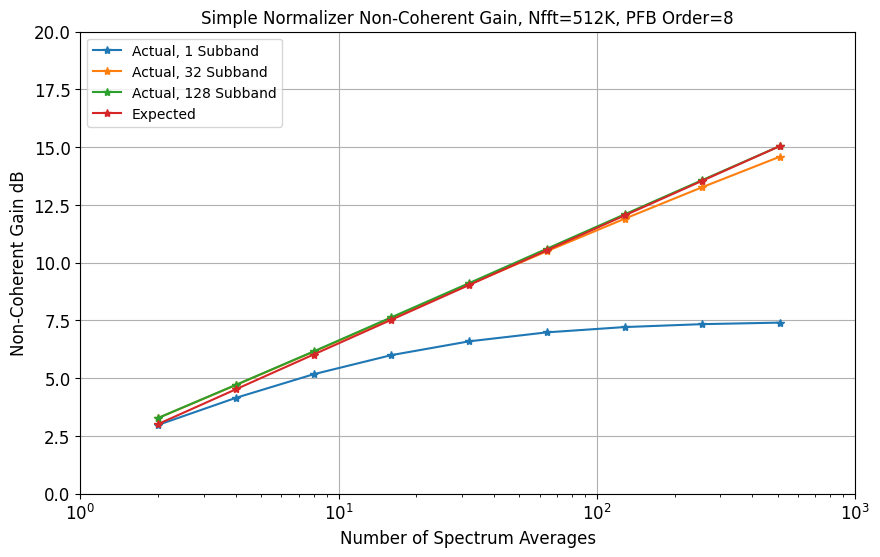

In [6]:
n_avg_array = np.zeros(log2_n_avg)
noncoh_snr_gain_db = np.zeros((len(n_subband_list),log2_n_avg))
noncoh_snr_gain_db_expected = np.zeros(log2_n_avg)
for i_avg in range(log2_n_avg):
    n_avg_array[i_avg] = n_sti* 2**(i_avg+1)
    noncoh_snr_gain_db_expected[i_avg] = s.db(expected_mean_std_ratio[i_avg])
    for i_sb_list,n_subband in enumerate(n_subband_list):
        noncoh_snr_gain_db[i_sb_list,i_avg] = s.db(avg_mean_std_ratio[i_sb_list,i_avg])

fig = plt.figure(figsize=(10, 6))
for i_sb_list,n_subband in enumerate(n_subband_list):
    plt.semilogx(n_avg_array,noncoh_snr_gain_db[i_sb_list,:],'-*',label=f'Actual, {n_subband} Subband')
plt.semilogx(n_avg_array,noncoh_snr_gain_db_expected,'-*',label='Expected')
plt.xlim(1,1000)
plt.ylim(0,20)
plt.xlabel('Number of Spectrum Averages')
plt.ylabel('Non-Coherent Gain dB')
plt.title(f'Simple Normalizer Non-Coherent Gain, Nfft={fine_fft_size//1024}K, PFB Order={pfb_order}')
plt.legend(loc='upper left')
plt.grid()

plt.savefig(output_dir+f'04-simple-norm-mean-std-ratio-{n_subband}-sb.png',bbox_inches='tight')
plt.show()

In [7]:
det_out

,freq,f_index,margin_db,snr_db,snr_coh_db,noncoh_gain_db,peak_db,threshold_db,peak_value,threshold_value,norm_mean_value,norm_std_value
0,-0.450001,26214,8.114975,18.114975,3.380190,14.734785,5.021273,1.258523,3.177805,1.336141,1.0,0.033614
1,-0.350000,78643,8.503537,18.503537,3.435629,15.067908,5.059342,1.177092,3.205784,1.311322,1.0,0.031132
2,-0.250000,131072,8.729496,18.729496,3.570124,15.159372,5.152329,1.155551,3.275162,1.304834,1.0,0.030483
3,-0.150000,183501,8.533736,18.533736,3.394357,15.139379,5.030986,1.160230,3.184921,1.306240,1.0,0.030624
4,-0.049999,235930,8.645558,18.645558,3.504622,15.140936,5.106931,1.159865,3.241105,1.306130,1.0,0.030613
5,0.049999,288358,8.605076,18.605076,3.482724,15.122352,5.091801,1.164228,3.229833,1.307443,1.0,0.030744
6,0.150000,340787,8.496044,18.496044,3.441759,15.054285,5.063561,1.180330,3.208899,1.312300,1.0,0.031230
7,0.250000,393216,8.620710,18.620710,3.525097,15.095613,5.121099,1.170531,3.251696,1.309342,1.0,0.030934
8,0.350000,445645,8.396380,18.396380,3.389201,15.007179,5.027450,1.191587,3.182329,1.315705,1.0,0.031571
9,0.450001,498074,8.135364,18.135364,3.407544,14.727820,5.040037,1.260276,3.191565,1.336681,1.0,0.033668


In [8]:
whos

Variable                      Type                          Data/Info
---------------------------------------------------------------------
H_edge_db                     float                         0.0
Hsq                           ndarray                       524288: 524288 elems, type `float32`, 2097152 bytes (2.0 Mb)
Hsq_db                        ndarray                       524288: 524288 elems, type `float32`, 2097152 bytes (2.0 Mb)
Hsq_est                       ndarray                       524288: 524288 elems, type `float64`, 4194304 bytes (4.0 Mb)
Hsq_est_db                    ndarray                       524288: 524288 elems, type `float64`, 4194304 bytes (4.0 Mb)
Hsq_pfb                       ndarray                       524288: 524288 elems, type `float32`, 2097152 bytes (2.0 Mb)
Hsq_pfb_db                    ndarray                       524288: 524288 elems, type `float32`, 2097152 bytes (2.0 Mb)
Path                          type                          <class 'pa

In [9]:
# Beep in WSL
os.system("powershell.exe '[console]::beep(261.6,700)'")

0